
    K-평균 알고리즘
    군집화(Cluster) 문제를 풀기위한 비지도학습 알고리즘
    * 지도학습: 데이터 라벨링하는 작업, 특정 데이터를 입출력하는 것을 반복해서 학습시키는 방식
    주어진 데이터를 지정된 군집 개수(K)로 그룹화하여 그룹내의 동일한 성질을 가지고 다른 그룹과
    차별화 시키는 것.
    알고리즘의 결과는 중심(centroid) 라고 부르는 K개의 점(dot)으로, 이들은 각기 다른 그룹의 중심점을
    나타낸다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [3]:
num_points = 2000
vectors_set = []
for i in range(num_points):
    if np.random.random() > 0.5:
        vectors_set.append([np.random.normal(0.0, 0.9),
                           np.random.normal(0.0, 0.9)])
    else:
        vectors_set.append([np.random.normal(3.0, 0.5),
                           np.random.normal(2.0, 0.5)])

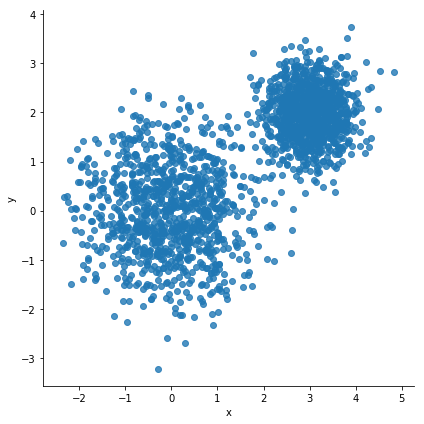

In [4]:
df = pd.DataFrame({
        "x": [v[0] for v in vectors_set],
        "y": [v[1] for v in vectors_set]
    })
sns.lmplot("x", "y", data = df, fit_reg = False, height = 6)
plt.show()


#### k-평균 클러스터링 알고리즘은 클러스터링 방법 중 분할법에 속한다. 
#### 분할법은 주어진 데이터를 여러 파티션 (그룹) 으로 나누는 방법이다. 
#### 예를 들어 n개의 데이터 오브젝트를 입력받았다고 가정하자. 
#### 이 때 분할법은 입력 데이터를 n보다 작거나 같은 k개의 그룹으로 나누는데, 
#### 이 때 각 군집은 클러스터를 형성하게 된다. 다시 말해, 데이터를 
#### 한 개 이상의 데이터 오브젝트로 구성된 k개의 그룹으로 나누는 것이다. 
#### 이 때 그룹을 나누는 과정은 거리 기반의 그룹간 비유사도 (dissimilarity) 와 
#### 같은 비용 함수 (cost function) 을 최소화하는 방식으로 이루어지며, 
#### 이 과정에서 같은 그룹 내 데이터 오브젝트 끼리의 유사도는 증가하고, 
#### 다른 그룹에 있는 데이터 오브젝트와의 유사도는 감소하게 된다.
#### [7] k-평균 알고리즘은 각 그룹의 중심 (centroid)과 그룹 내의 데이터 
#### 오브젝트와의 거리의 제곱합을 비용 함수로 정하고, 
#### 이 함수값을 최소화하는 방향으로 각 데이터 오브젝트의 
#### 소속 그룹을 업데이트 해 줌으로써 클러스터링을 수행하게 된다.


In [5]:
vectors = tf.constant(vectors_set) # 상수 텐서 생성 : 모든 데이터를 텐서로 옮긴다

In [7]:
k = 5  # 입력데이터에서 무작위로 K개의 데이터를 선택함. 여기서는 4개
centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors), [0,0], [k,-1]))
# K개의 데이터 포인터는 2D 텐서로 저장됨

In [9]:
#'---------- 텐서의 구조 보기 ----------'
vectors.get_shape()  # (2000, 2)
# D0 차원의 크기가 2000개이고 D1 차원은 크기가 2(각 점의 x, y 좌표) 
print(centroids.get_shape())  # (4, 2)

(5, 2)


In [ ]:
# 센트로이드는 D0 차원의 크기가 4개이고 D1 차원은 vectors 와 동일한 2인 행렬
expanded_vectors = tf.expand_dims(vectors, 0)  # 두 텐서에 차원을 추가
expanded_centroids = tf.expand_dims(centroids, 1) # 두 텐서를 2차원에서 3차원으로 만들어 뺄셈 가능하도록

In [ ]:
# 크기를 맞추는 작업
# 각 점에 대한 유클리드 제곱거리 알고리즘 무한 반복
# assignments = tf.argmin(tf.reduce_sum(tf.square(tf.subtract(expanded_vectors, 
#                                                             expanded_centroids
#                                                             )), 2) , 0)

diff = tf.subtract(expanded_vectors, expanded_centroids) # 각 벡터와 중심의 차이
sqr = tf.square(diff) # diff 텐서의 제곱값
distances = tf.reduce_sum(sqr, 2) # 매개변수로 지정한 차원(D2)가 줄어듬
assignments = tf.argmin(distances, 0) # tf.argmin() 중심 값들이 들어있는 D0 차원에서 가장 작은 값의 인덱스 리턴

# 새로운 중심 계산하기
# 매 반복마다 새롭게 그룹화를 하면서 각 그룹에 해당하는 새로운 중심을 다시 계산

In [ ]:
means = tf.concat([tf.reduce_mean(tf.gather(
                vectors, tf.reshape(tf.where(tf.equal(assignments, c)), [1, -1])),
                                  reduction_indices=[1]) for c in range(k) ] , 0)
update_centroids = tf.assign(centroids, means)

init_op = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init_op)

for i in range(100):
    _, centroid_values, assignment_values = sess.run([
            update_centroids,
            centroids,
            assignments
        ])

    # assignment_values 텐서의 결과를 확인하기 위한 결과 그림 그리기
data = {"x" : [], "y" : [], "cluster": [] }
for i in range(len(assignment_values)):
    data["x"].append(vectors_set[i][0])
    data["y"].append(vectors_set[i][1])
    data["cluster"].append(assignment_values[i])

df = pd.DataFrame(data)
sns.lmplot("x", "y", data = df,  fit_reg = False, height = 6, hue = "cluster", legend = False)
plt.show()